In [1]:
from IPython.display import SVG
from matplotlib      import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from collections     import Counter

import numpy as np
import mido
import librosa as lbr
from   librosa.display     import specshow

from sklearn.preprocessing import binarize
from keras.models          import load_model
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
songName = './Test songs/Big Bill Broonzy & Chas Segar - Key to the Highway (Cover by Rog Bates).mp3'
harmMargin, nBins, nFrames = 4, 5, 5

song = lbr.effects.trim(lbr.load(songName)[0])[0]
songLen = int(lbr.get_duration(song))
print('Song duration\t{} min : {} sec'.format(songLen // 60, songLen % 60))

Song duration	2 min : 35 sec


In [3]:
songHarm = lbr.effects.harmonic(song, margin=harmMargin)
cqts = lbr.magphase(lbr.cqt(songHarm, fmin=lbr.note_to_hz('A0'), n_bins=88*nBins, bins_per_octave=12*nBins))[0]
print(cqts.shape[1], 'frames')

6710 frames


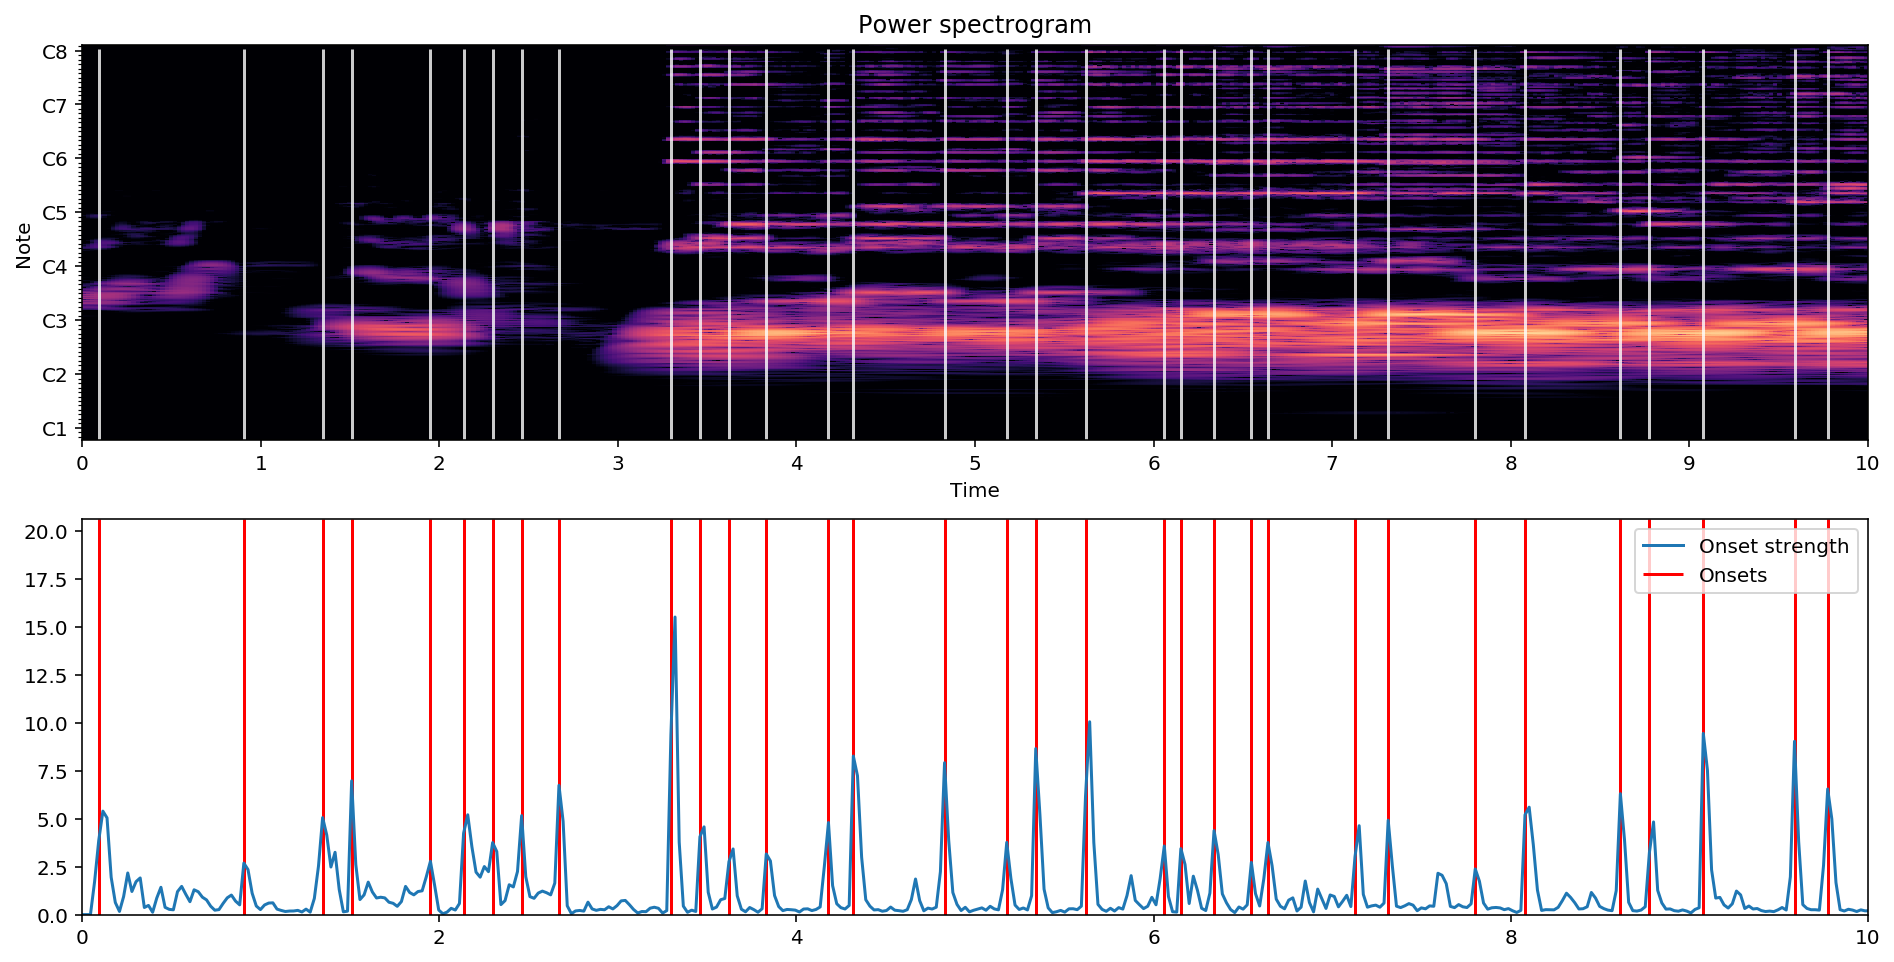

In [4]:
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(2, 1, 1)
plt.title('Power spectrogram')
specshow(lbr.amplitude_to_db(cqts, ref=np.max), x_axis='time', y_axis='cqt_note',
         fmin=lbr.note_to_hz('A0'), bins_per_octave=12*nBins)

o_env, frames = lbr.onset.onset_strength(song), lbr.onset.onset_detect(song)
times = lbr.frames_to_time(range(len(o_env)))
plt.vlines(times[frames], lbr.note_to_hz('A0'), lbr.note_to_hz('C8'), color='w', alpha=.8)

ax2 = plt.subplot(2, 1, 2)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[frames], 0, o_env.max(), color='r', label='Onsets')
plt.legend()
plt.ylim(0, o_env.max())

for a in [ax1, ax2]: a.set_xlim(0, 10)

In [5]:
print('cqts before norm\tin range [{:.2e} - {:.3f} - {:.3f}]'.format(cqts.min(), cqts.mean(), cqts.max()))
cqtBin = cqts.mean(1)
assert cqtBin.shape == (88 * nBins,)
print('average cqt bin\t\tin range [{:.2e} - {:.3f} - {:.3f}]'.format(cqtBin.min(), cqtBin.mean(), cqtBin.max()))

cqts /= cqts.max(0, keepdims=True)
# Ideally there should only be one cqt=1 per frame after normalization, but there may be slightly more
numOnesRatio = cqts.shape[1] / len(np.hstack([(c == 1).nonzero()[0] for c in cqts.T]))
assert (.999 < numOnesRatio <= 1)
assert numOnesRatio == 1

print('cqts after frame norm\tin range [{:.2e} - {:.3f} - {:.3f}]'.format(cqts.min(), cqts.mean(), cqts.max()))
cqtBin = cqts.mean(1)
assert cqtBin.shape == (88 * nBins,)
print('average cqt bin\t\tin range [{:.2e} - {:.3f} - {:.3f}]'.format(cqtBin.min(), cqtBin.mean(), cqtBin.max()))

# Not using batch norm, even though:
maxBins = cqts.max(1)
assert maxBins.shape == (440,)
print('All maximums should be ones, but there are only {:.1%} ones and min of max is {:.2e}'.format(
    maxBins[maxBins == 1].sum() / len(maxBins), maxBins.min()))

assert cqts.min() > 0
cqts = np.vstack([np.zeros((nFrames // 2, cqts.shape[0]), cqts.dtype), cqts.T,
                  np.zeros((nFrames // 2, cqts.shape[0]), cqts.dtype)])
cqts = np.array([cqts[range(f, f + nFrames)] for f in range(len(cqts) - nFrames + 1)])

cqts before norm	in range [8.00e-08 - 0.131 - 27.575]
average cqt bin		in range [9.49e-05 - 0.131 - 2.648]
cqts after frame norm	in range [1.42e-08 - 0.028 - 1.000]
average cqt bin		in range [3.25e-05 - 0.028 - 0.407]
All maximums should be ones, but there are only 29.5% ones and min of max is 1.77e-03


# From Kumhansl and Schmuckler as reported here:
http://rnhart.net/articles/key-finding/

In [6]:
chroma = lbr.feature.chroma_cqt(songHarm)[:, frames].sum(1)
major = [np.corrcoef(chroma, np.roll([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], i))[0, 1] for i in range(12)]
minor = [np.corrcoef(chroma, np.roll([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], i))[0, 1] for i in range(12)]

keySignature = (['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][
    major.index(max(major)) if max(major) > max(minor) else minor.index(max(minor)) - 3]
                + ('m' if max(major) < max(minor) else ''))
keySignature

'E'

In [7]:
model = load_model('Model Train71 Val65 Frame59.h5') # HDF5 file
yProb = model.predict(cqts, verbose=1)
SVG(model_to_dot(model, True, False, 'LR').create(format='svg'))

C:\Anaconda3_64\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


6710/6710 [==============================] - 9s 1ms/step


#### There are false positives in high octaves, probably because we provide less cqt harmonics for them in CNN.<br>If it is too annoing, you can use higher threshold for higher octaves. Can't think of any better solution for now :(

In [8]:
#yPredAll = np.hstack([binarize(yProb[:, :52], .5), binarize(yProb[:, 52:64], .6), binarize(yProb[:, 64:], .7)])
yPredAll = binarize(yProb, .5)
yPred = yPredAll.sum(0)
if len(frames) > 1:
    yPred = yPredAll[:(frames[0] + frames[1]) // 2].sum(0)
    for i, fr in enumerate(frames[1:-1]):
        yPred = np.vstack([yPred, yPredAll[(frames[i] + fr) // 2 : (fr + frames[i + 2]) // 2].sum(0)])
    yPred = np.vstack([yPred, yPredAll[(frames[-2] + frames[-1]) // 2 :].sum(0)])

notes = Counter()
for row in yPred: notes.update(Counter(np.argwhere(row).ravel() % 12))
gamma = [n for _, n in sorted([(count, ['A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab'][i])
                for i, count in notes.items()], reverse=True)[:7]]
blacks = sorted(n for n in gamma if len(n) > 1)
blacks, gamma

(['Ab', 'C#', 'F#'], ['E', 'A', 'B', 'D', 'C#', 'F#', 'Ab'])

In [9]:
MajorMinor = lambda mj, mn: mj if gamma.index(mj) < gamma.index(mn) else mn + 'm'

if len(blacks) == 0: keySignature = MajorMinor('C', 'A')

elif len(blacks) == 1:
    if blacks[0] == 'F#':
        assert 'F' not in gamma
        keySignature = MajorMinor('G', 'E')
    elif blacks[0] == 'Bb':
        assert 'B' not in gamma
        keySignature = MajorMinor('F', 'D')
    else: assert False

elif len(blacks) == 2:
    if blacks == ['C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma
        keySignature = MajorMinor('D', 'B')
    elif blacks == ['Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma
        keySignature = MajorMinor('Bb', 'G')
    else: assert False

elif len(blacks) == 3:
    if blacks == ['Ab', 'C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('A', 'F#')
    elif blacks == ['Ab', 'Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma
        keySignature = MajorMinor('Eb', 'C')
    else: assert False

elif len(blacks) == 4:
    if blacks == ['Ab', 'C#', 'Eb', 'F#']:
        assert 'C' not in gamma and 'D' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('E', 'C#')
    elif blacks == ['Ab', 'Bb', 'C#', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma and 'D' not in gamma
        keySignature = MajorMinor('Ab', 'F')
    else: assert False

elif 'B' in gamma and 'E' in gamma: keySignature = MajorMinor('B', 'Ab')
elif 'C' in gamma and 'F' in gamma: keySignature = MajorMinor('C#', 'Bb')
else: assert False

keySignature

'A'

In [10]:
microSecPerBeat, ppqn = mido.bpm2tempo(lbr.beat.tempo(song).mean()), 480
midi, track = mido.MidiFile(ticks_per_beat=ppqn), mido.MidiTrack()
midi.tracks.append(track)
track.append(mido.MetaMessage('text',          text  = 'Automatically transcribed from audio:\r\n\t' + songName))
track.append(mido.MetaMessage('copyright',     text  = 'Used software created by Boris Shakhovsky'))
track.append(mido.MetaMessage('set_tempo',     tempo = microSecPerBeat))
track.append(mido.MetaMessage('key_signature', key   = keySignature))

for i, note in enumerate(np.argwhere(yPred[0]).ravel()):
    track.append(mido.Message('note_on', note=note+21, velocity=int(0x30 + 0x50 * yProb[frames[0]][note])))
for i, fr in enumerate(frames[1:]):
    track.append(mido.Message('note_off', note=0, time=int(mido.second2tick(
        lbr.frames_to_time(fr) - lbr.frames_to_time(frames[i]), ppqn, microSecPerBeat))))
    for note in np.argwhere(yPred[i]).ravel():
        track.append(mido.Message('note_off', note=note+21))
    for note in np.argwhere(yPred[i + 1]).ravel():
        track.append(mido.Message('note_on', note=note+21, velocity=int(0x30 + 0x50 * yProb[fr][note])))

midiOutFile = '.'.join(songName.split('.')[:-1]) + '.mid'
midi.save(midiOutFile)
print('"{}" saved'.format(midiOutFile))

"./Test songs/Big Bill Broonzy & Chas Segar - Key to the Highway (Cover by Rog Bates).mid" saved
